# Dataset creation

In [11]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import tensorflow as tf
from src.models import build_baseline_cnn
from src.train import compile_and_train
from src.data_loader import collect_image_paths, stratified_split

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

DATASET_PATH = "../data/raw/PlantVillage"

image_paths, labels = collect_image_paths(DATASET_PATH)
X_train, y_train, X_val, y_val, X_test, y_test = stratified_split(
    image_paths, labels
)

class_names = sorted(set(labels))
class_to_index = {name: idx for idx, name in enumerate(class_names)}

y_train = [class_to_index[y] for y in y_train]
y_val = [class_to_index[y] for y in y_val]
y_test = [class_to_index[y] for y in y_test]


In [12]:
def build_dataset(image_paths, labels, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((image_paths, labels))

    def load_image(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMAGE_SIZE)
        img = img / 255.0
        return img, label

    ds = ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(1000)

    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [13]:
train_ds = build_dataset(X_train, y_train, shuffle=True)
val_ds = build_dataset(X_val, y_val)
test_ds = build_dataset(X_test, y_test)


##### Train baseline model

In [14]:
model = build_baseline_cnn(
    input_shape=(224, 224, 3),
    num_classes=len(class_names)
)

history = compile_and_train(model, train_ds, val_ds, epochs=10)


Epoch 1/10
452/452 [==============================] - 44s 93ms/step - loss: 1.4832 - accuracy: 0.5290 - val_loss: 0.8548 - val_accuracy: 0.7229
Epoch 2/10
452/452 [==============================] - 34s 75ms/step - loss: 0.6532 - accuracy: 0.7837 - val_loss: 0.6473 - val_accuracy: 0.7936
Epoch 3/10
452/452 [==============================] - 35s 77ms/step - loss: 0.4210 - accuracy: 0.8567 - val_loss: 0.4820 - val_accuracy: 0.8463
Epoch 4/10
452/452 [==============================] - 35s 76ms/step - loss: 0.2625 - accuracy: 0.9106 - val_loss: 0.4982 - val_accuracy: 0.8475
Epoch 5/10
452/452 [==============================] - 35s 76ms/step - loss: 0.2034 - accuracy: 0.9312 - val_loss: 0.5427 - val_accuracy: 0.8466
Epoch 6/10
452/452 [==============================] - 34s 75ms/step - loss: 0.1363 - accuracy: 0.9528 - val_loss: 0.5365 - val_accuracy: 0.8534
Epoch 7/10
452/452 [==============================] - 34s 75ms/step - loss: 0.0901 - accuracy: 0.9691 - val_loss: 0.5360 - val_accuracy:

In [22]:
import os

# Create directory if it doesn't exist
os.makedirs("../results/metrics", exist_ok=True)

# Save trained baseline model
MODEL_PATH = "../results/metrics/baseline_cnn_model.h5"
model.save(MODEL_PATH)

print(f"Baseline CNN model saved at: {MODEL_PATH}")


Baseline CNN model saved at: ../results/metrics/baseline_cnn_model.h5


In [23]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}")


97/97 [==============================] - 4s 39ms/step - loss: 0.6355 - accuracy: 0.8608
Test accuracy: 0.8608


In [24]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print(classification_report(y_true, y_pred, target_names=class_names))


1/1 [==============================] - 0s 25ms/step
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.83      0.72      0.77       149
                     Pepper__bell___healthy       0.93      0.93      0.93       221
                      Potato___Early_blight       0.94      0.88      0.91       150
                       Potato___Late_blight       0.76      0.80      0.78       150
                           Potato___healthy       0.74      0.61      0.67        23
                      Tomato_Bacterial_spot       0.91      0.93      0.92       319
                        Tomato_Early_blight       0.61      0.75      0.67       150
                         Tomato_Late_blight       0.78      0.85      0.81       287
                           Tomato_Leaf_Mold       0.81      0.83      0.82       143
                  Tomato_Septoria_leaf_spot       0.80      0.81      0.81       266
Tomato_Spide

In [25]:
with open("../results/metrics/baseline_metrics.txt", "w") as f:
    f.write(f"Train accuracy (final): {history.history['accuracy'][-1]:.4f}\n")
    f.write(f"Validation accuracy (final): {history.history['val_accuracy'][-1]:.4f}\n")
    f.write(f"Test accuracy: {test_acc:.4f}\n")


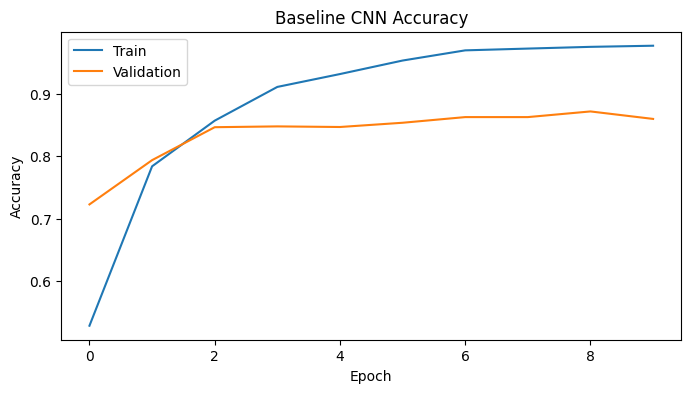

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Baseline CNN Accuracy")

plt.savefig("../results/plots/baseline_accuracy_curve.png", dpi=300)
plt.show()


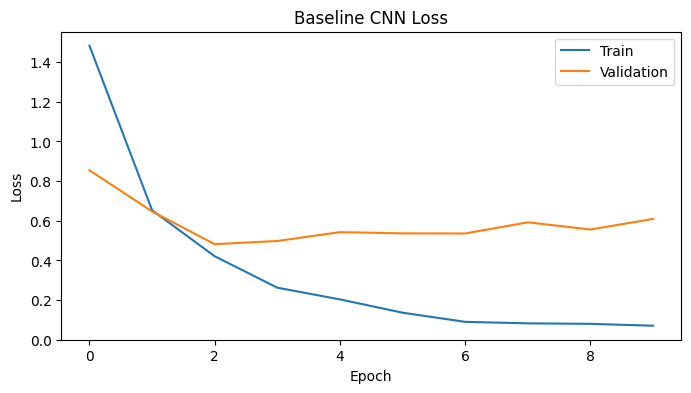

In [27]:
plt.figure(figsize=(8, 4))
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Baseline CNN Loss")

plt.savefig("../results/plots/baseline_loss_curve.png", dpi=300)
plt.show()
